# Automated Essay Scoring

This version includes split domain1_score into bins and remove outliers

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print('Hi mom')

Hi mom


In [3]:
# import important libraries and download data
import os
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline
sns.set_theme(style='whitegrid')
# ! git clone https://github.com/Gaurav-Pande/AES_DL.git && mv AES_DL/data .
# ! pip install transformers

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Declaring some visualization methods to plot accuracy and model diagram
def plot_accuracy_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_acrchitecture(filename, model):
    plot_model(model, to_file=str(filename) + '.png')

In [5]:
# method to split data into sets
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    
    return (essay_sets, min_scores, max_scores)

In the below cell, we can see the data we need to operate. We essentially drops the column, we dont need and keep the domain_score only along with essay text.

In [6]:
dataset_path = "./data/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")
data.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.shape

(12976, 28)

In [8]:
data['essay'][0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [8]:
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]
essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)
sets = [set1,set2,set3,set4,set5,set6,set7,set8]
data.head()

/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_30392/2675578851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_set.dropna(axis=1, inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_30392/1243294380.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_30392/1243294380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

Set 1 : Essays =  1783 	 Attributes =  6
Set 2 : Essays =  1800 	 Attributes =  9
Set 3 : Essays =  1726 	 Attributes =  6
Set 4 : Essays =  1770 	 Attributes =  6
Set 5 : Essays =  1805 	 Attributes =  6
Set 6 : Essays =  1800 	 Attributes =  6
Set 7 : Essays =  1569 	 Attributes =  14
Set 8 : Essays =  723 	 Attributes =  18


/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_30392/1243294380.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set8.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [9]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

## Normalize score

Each set has different score range, so we are going to normalize them to 0-1

In [10]:
# Add word counts column
data['word_count'] = data['essay'].str.strip().str.split().str.len()
data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1,1,"Dear local newspaper, I think effects computer...",8,338
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,419
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,279
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,524
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,465


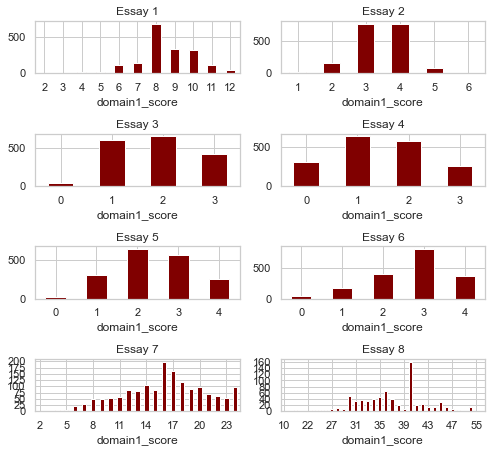

In [11]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharey=False)

for i in range(4):
    for j in range(2):
        topic_number += 1
        data[data['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)

ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# Normalize domain1_score of all sets from 0 to 1

for topic in range(1, 9):
    topic_set = data[data['essay_set'] == topic]
    min_set = topic_set['domain1_score'].min()
    max_set = topic_set['domain1_score'].max()

    data.loc[data['essay_set'] == topic, 'domain1_score'] = data[data['essay_set'] == topic]['domain1_score'].apply(lambda x: (x - min_set) / (max_set - min_set))
    # data[data['essay_set'] == topic]['domain1_score'].apply(lambda x: (x - min_set) / (max_set - min_set))
    # data[data['essay_set'] == topic]['domain1_score']

data

,essay_id,essay_set,essay,domain1_score,word_count
0,1,1,"Dear local newspaper, I think effects computer...",0.60,338
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.70,419
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.50,279
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.80,524
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.60,465
...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,0.50,845
12972,21628,8,I never understood the meaning laughter is th...,0.44,546
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",0.60,817
12974,21630,8,Trippin' on fen...,0.60,562


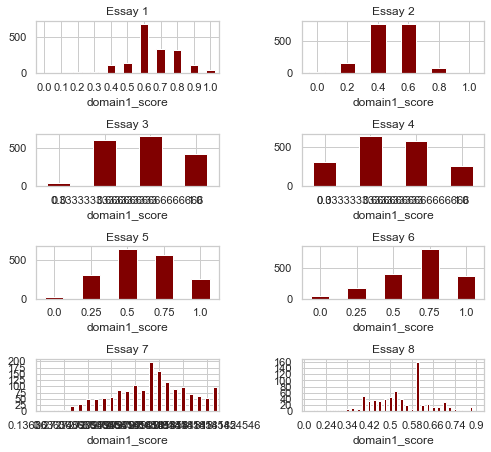

In [13]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharey=False)

for i in range(4):
    for j in range(2):
        topic_number += 1
        data[data['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)

ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# Split them into bins

for i in data.domain1_score:
  data.loc[data['domain1_score'] <= 0.2, 'domain1_score'] = 0.2
  data.loc[(data['domain1_score'] > 0.2) & (data['domain1_score'] <=0.4 ), 'domain1_score'] = 0.4
  data.loc[(data['domain1_score'] > 0.4) & (data['domain1_score'] <= 0.6), 'domain1_score'] = 0.6
  data.loc[(data['domain1_score'] > 0.6) & (data['domain1_score'] <= 0.8), 'domain1_score'] = 0.8
  data.loc[(data['domain1_score'] > 0.8) & (data['domain1_score'] <= 1), 'domain1_score'] = 1

data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1,1,"Dear local newspaper, I think effects computer...",0.6,338
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.8,419
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.6,279
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.8,524
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.6,465


In [15]:
# Using qcut to divide into equally sized bins

# test_df = data.copy()
#
# for i in range(1, 9):
#     test_df.loc[test_df.essay_set == i, 'score_range'] = pd.qcut(test_df.loc[test_df.essay_set == i, 'domain1_score'], q=5, precision=0)
#
# test_df.head()

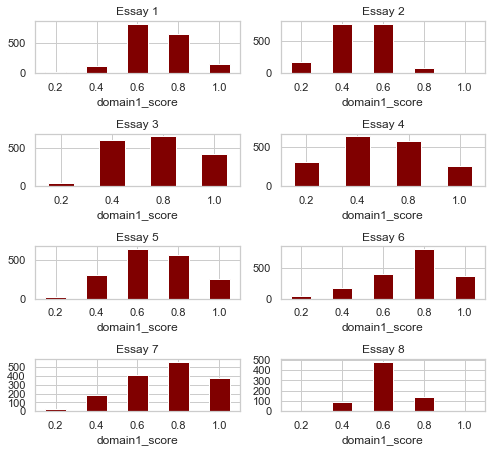

In [16]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharey=False)

for i in range(4):
    for j in range(2):
        topic_number += 1
        data[data['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)

ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

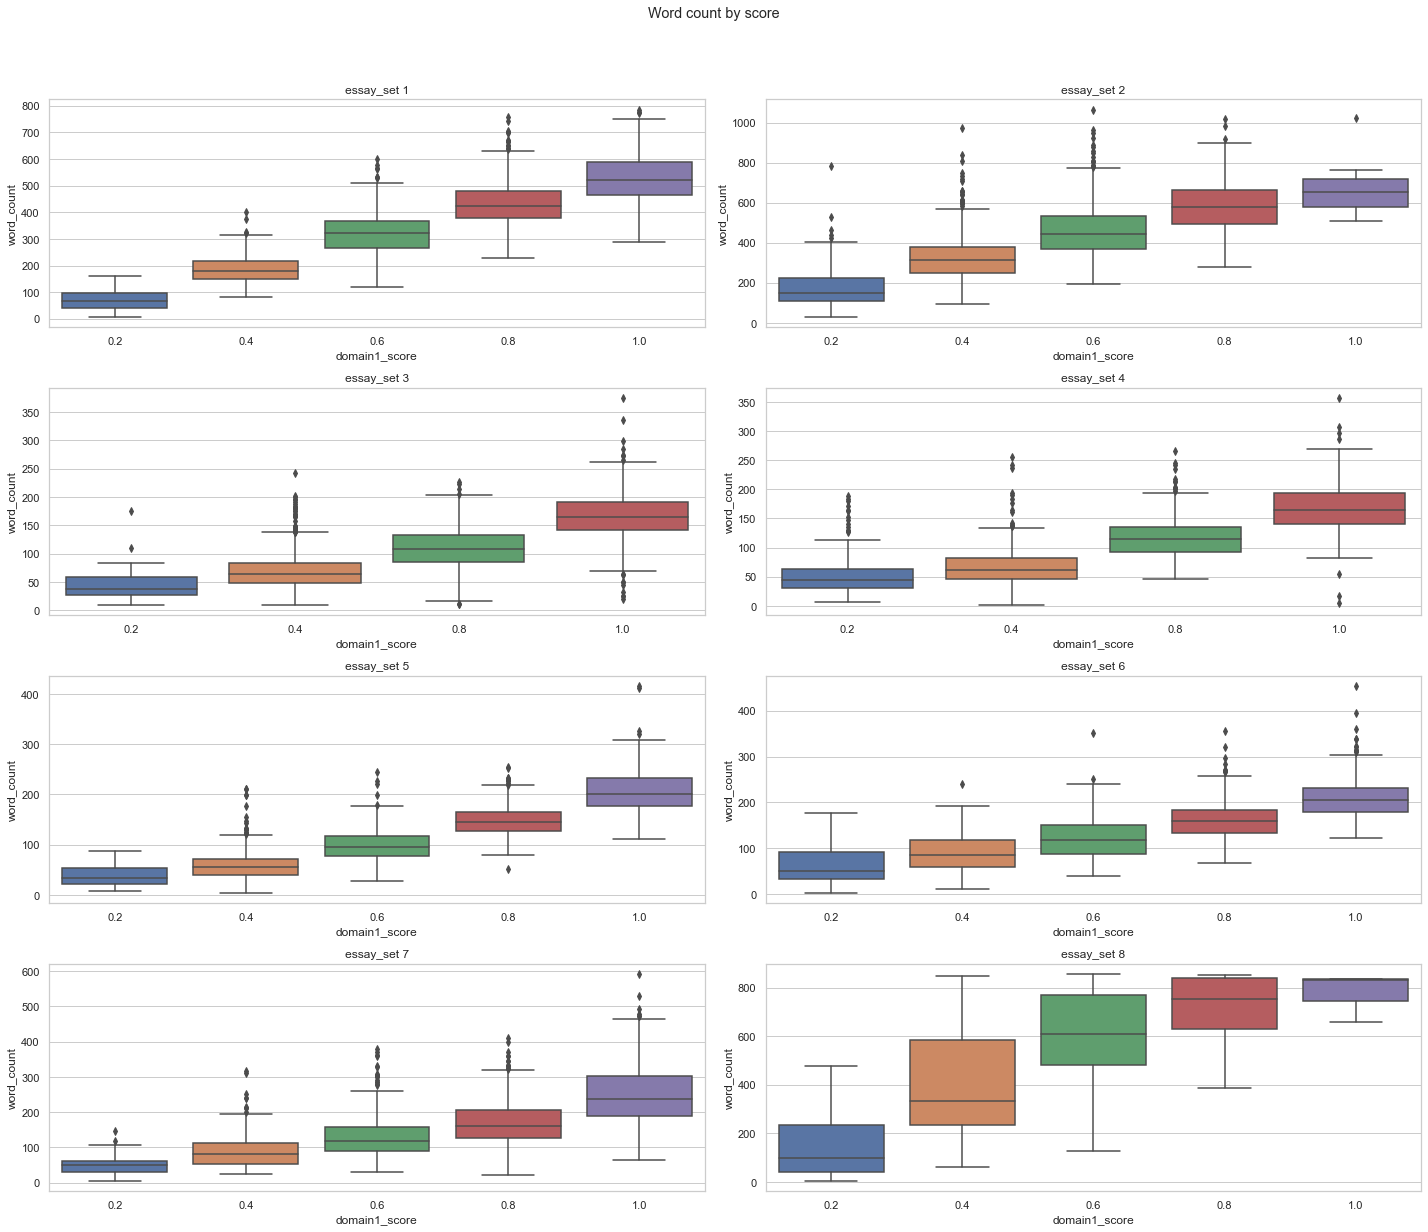

In [17]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(20, 18))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.boxplot(x='domain1_score', y='word_count', data=data[data['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('essay_set %i' % topic_number)

plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Remove outliers

## Remove outliers from set 1

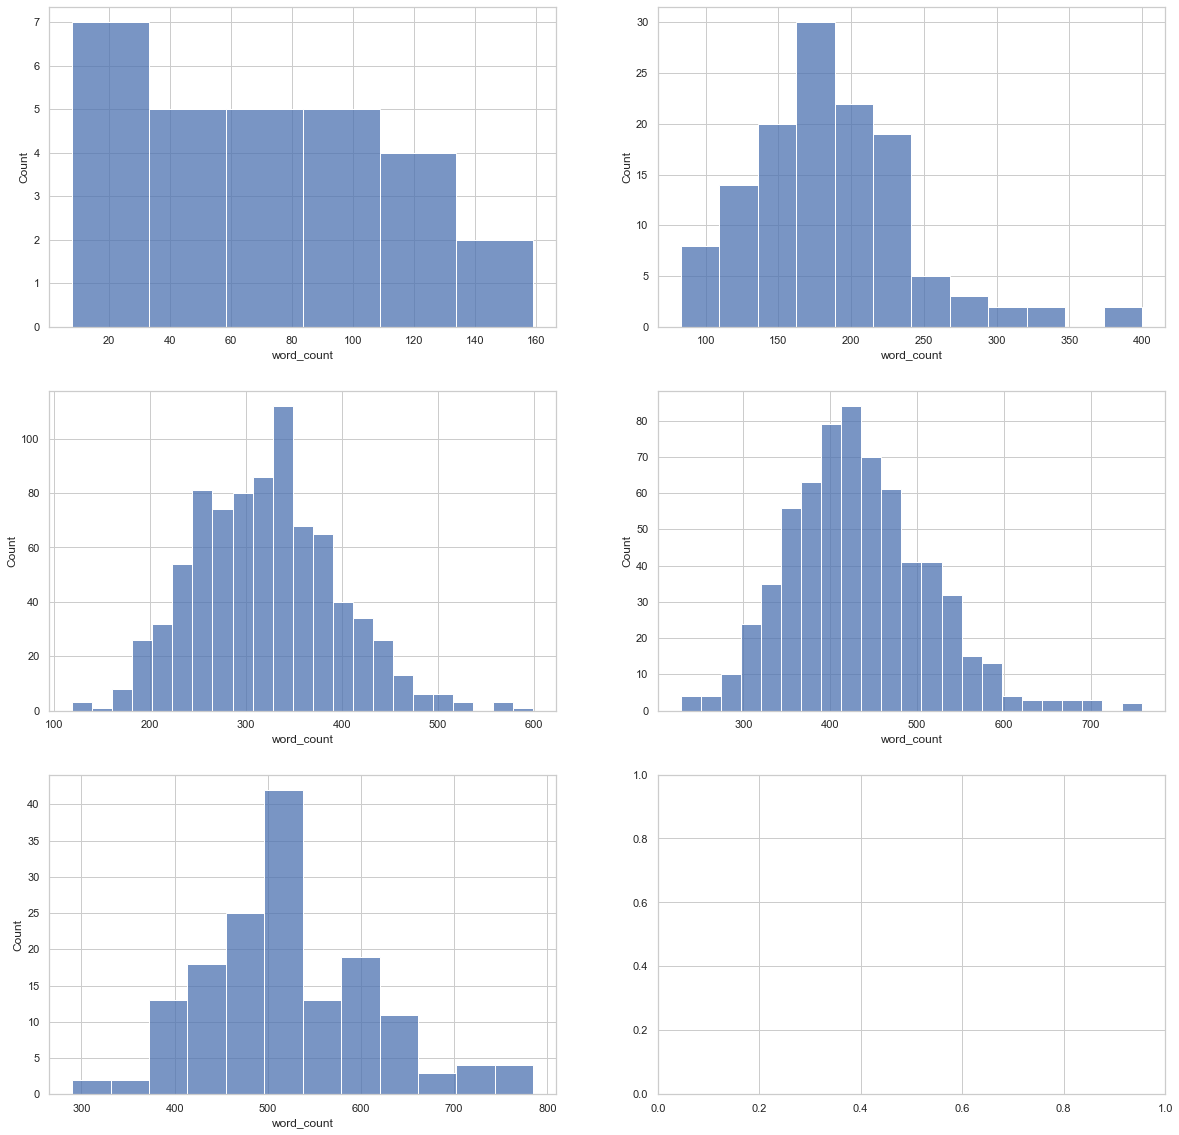

In [18]:
# Plot word length distribution of each score
def plot_word_length_each_score(essay_topic):
    fig, ax = plt.subplots(3, 2, figsize=(20, 20))

    scores = [0.2, 0.4, 0.6, 0.8, 1]
    idx = 0
    for i in range(3):
        for j in range(2):
            if idx < len(scores):
                topic = data[data.essay_set == essay_topic]
                sns.histplot(topic[topic['domain1_score'] == scores[idx]]['word_count'], ax=ax[i, j])
                idx += 1
    plt.show()

plot_word_length_each_score(1)

In [19]:
topic = data[data.essay_set == 1]
temp1 = topic[(topic['domain1_score'] == 0.4) & (topic['word_count'] > 350)]
temp2 = topic[(topic['domain1_score'] == 0.6) & (topic['word_count'] > 550)]
temp3 = topic[(topic['domain1_score'] == 0.8) & (topic['word_count'] > 700)]
temp = pd.concat([temp1, temp2, temp3])
data = data[~data.isin(temp)].dropna()
data.shape

(12967, 5)

## Remove outliers from set 2

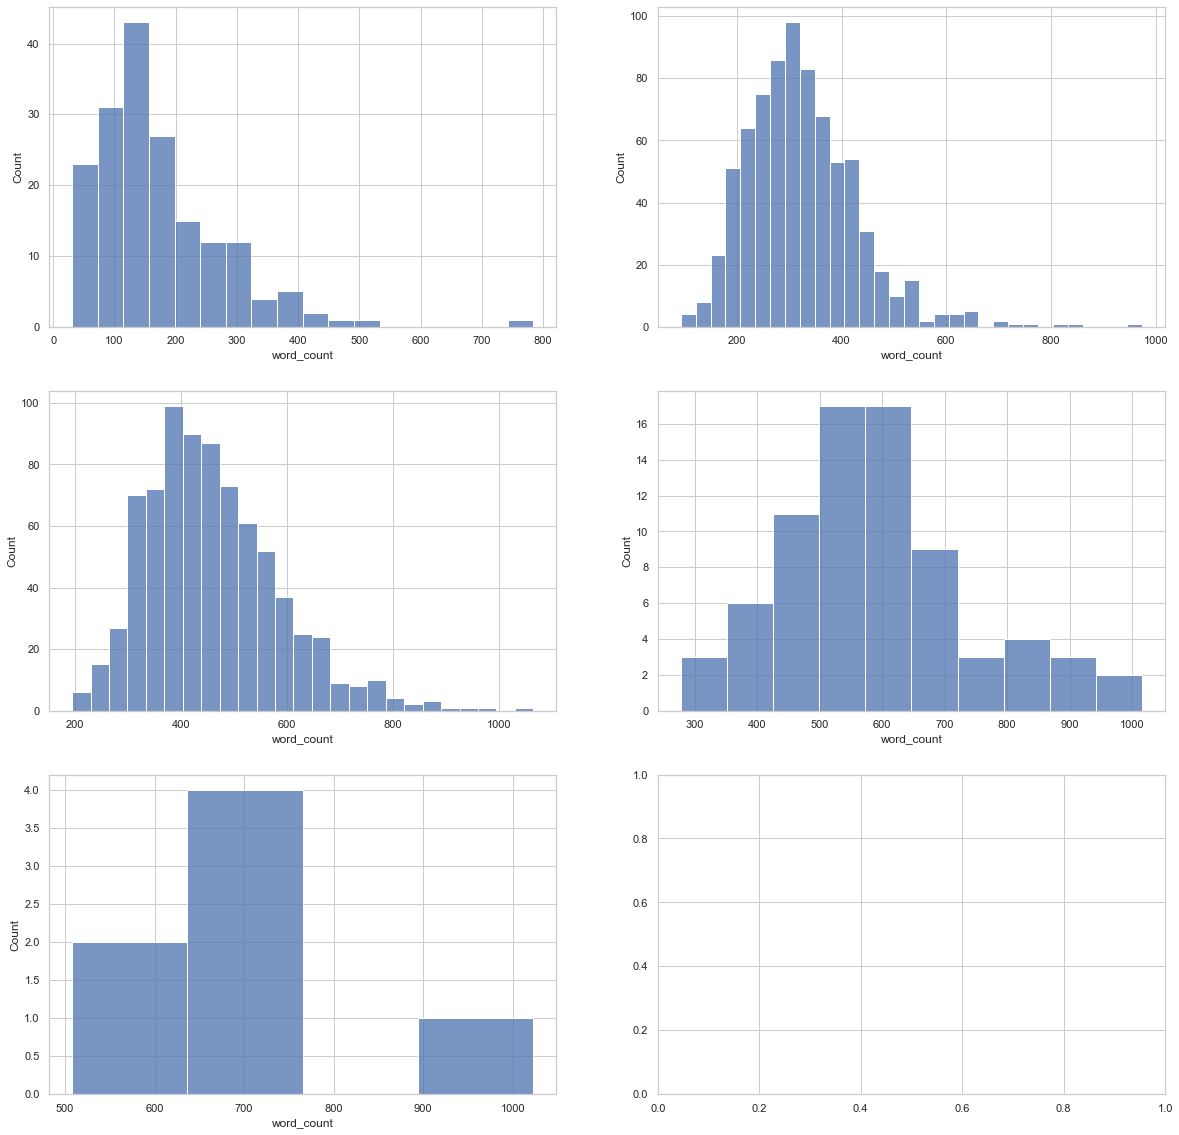

In [20]:
plot_word_length_each_score(2)

In [21]:
topic = data[data.essay_set == 2]
temp1 = topic[(topic['domain1_score'] == 0.2) & (topic['word_count'] > 550)]
temp2 = topic[(topic['domain1_score'] == 0.4) & (topic['word_count'] > 700)]
temp3 = topic[(topic['domain1_score'] == 0.6) & (topic['word_count'] > 850)]
temp4 = topic[(topic['domain1_score'] == 1) & (topic['word_count'] > 1000)]
temp = pd.concat([temp1, temp2, temp3, temp4])
data = data[~data.isin(temp)].dropna()
data.shape

(12951, 5)

## Remove outliers from set 3

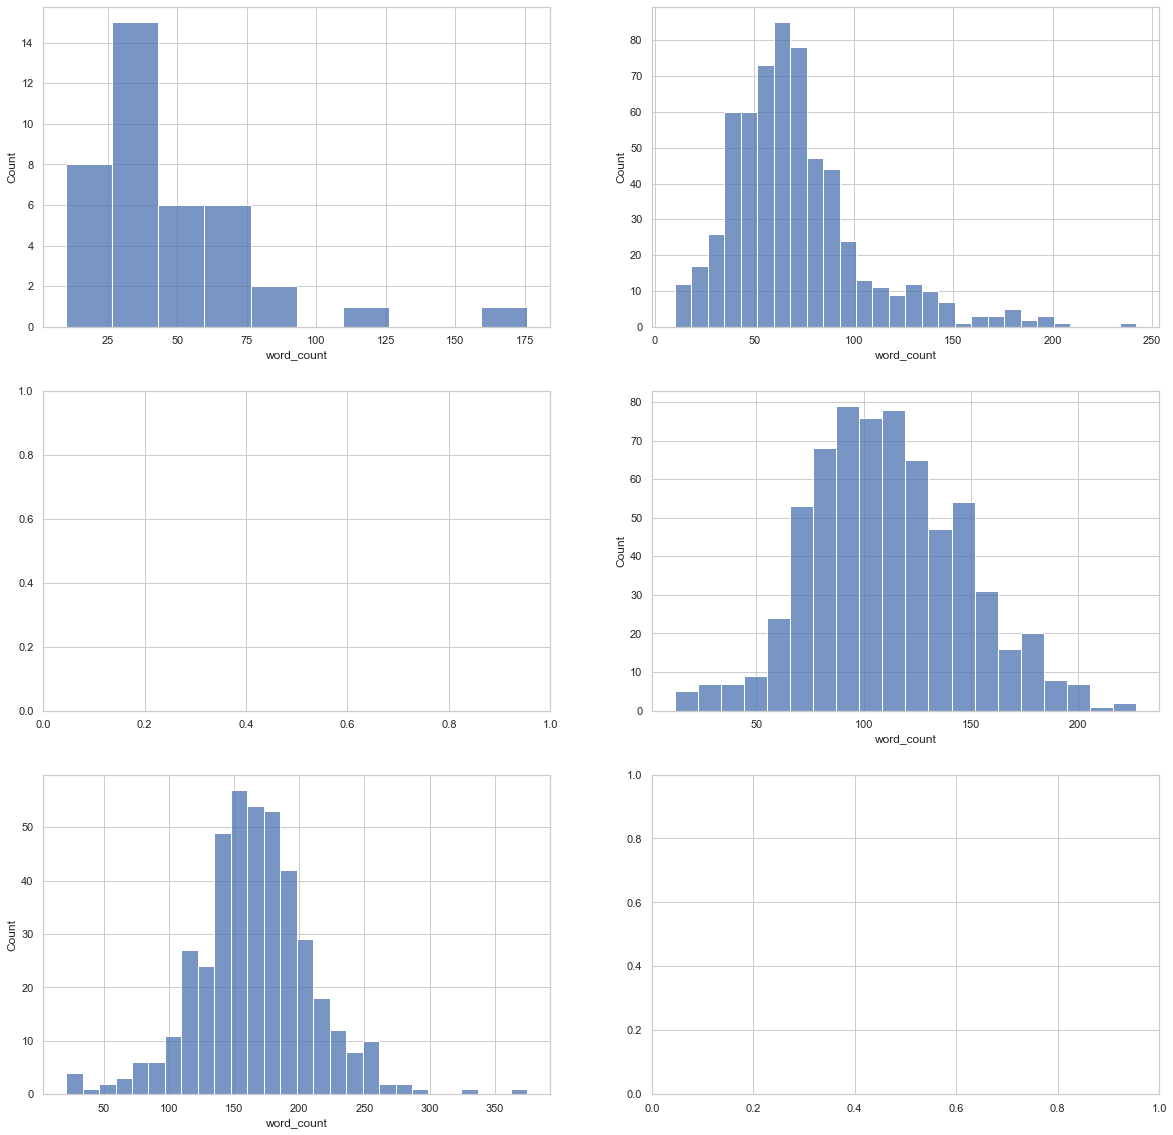

In [22]:
plot_word_length_each_score(3)

In [23]:
topic = data[data.essay_set == 3]
temp1 = topic[(topic['domain1_score'] == 0.2) & (topic['word_count'] > 100)]
temp2 = topic[(topic['domain1_score'] == 0.4) & (topic['word_count'] > 200)]
temp3 = topic[(topic['domain1_score'] == 1) & (topic['word_count'] > 300)]
temp = pd.concat([temp1, temp2, temp3])
data = data[~data.isin(temp)].dropna()
data.shape

(12945, 5)

## Remove outliers from set 4

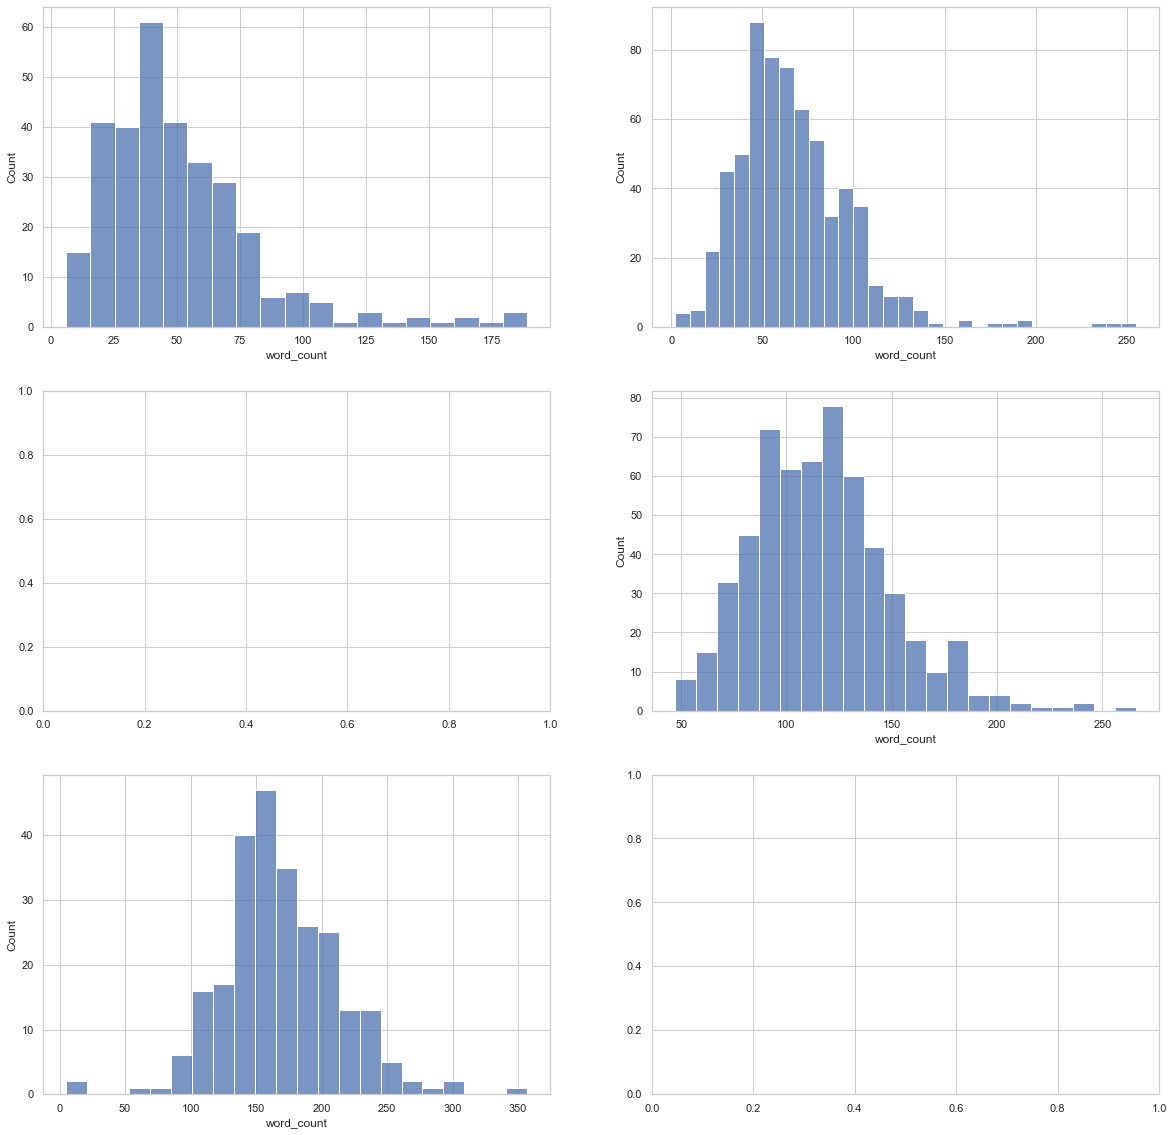

In [24]:
plot_word_length_each_score(4)

In [25]:
topic = data[data.essay_set == 4]
temp1 = topic[(topic['domain1_score'] == 0.4) & ((topic['word_count'] < 10) | (topic['word_count'] > 200))]
temp2 = topic[(topic['domain1_score'] == 1) & (topic['word_count'] < 10)]
temp = pd.concat([temp1, temp2])
data = data[~data.isin(temp)].dropna()
data.shape

(12939, 5)

## Remove outliers from set 5

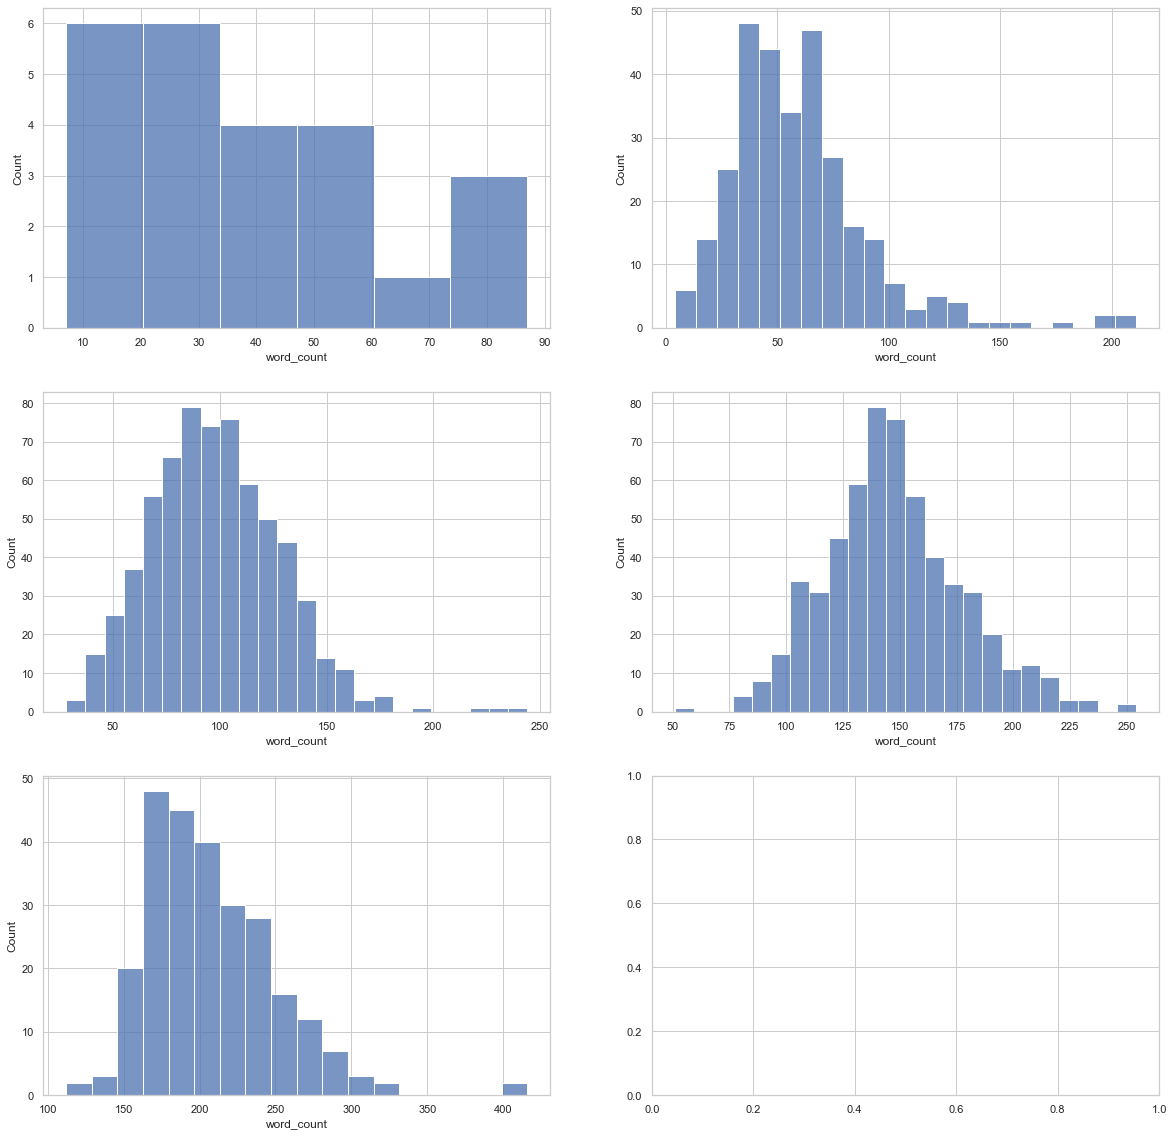

In [26]:
plot_word_length_each_score(5)

In [27]:
topic = data[data['essay_set'] == 5]
temp1 = topic[(topic['domain1_score'] == 0.4) & (topic['word_count'] < 10)]
temp2 = topic[(topic['domain1_score'] == 1) & (topic['word_count'] > 400)]
temp = pd.concat([temp1, temp2])
data = data[~data.isin(temp)].dropna()
data.shape

(12933, 5)

## Remove outliers from set 6

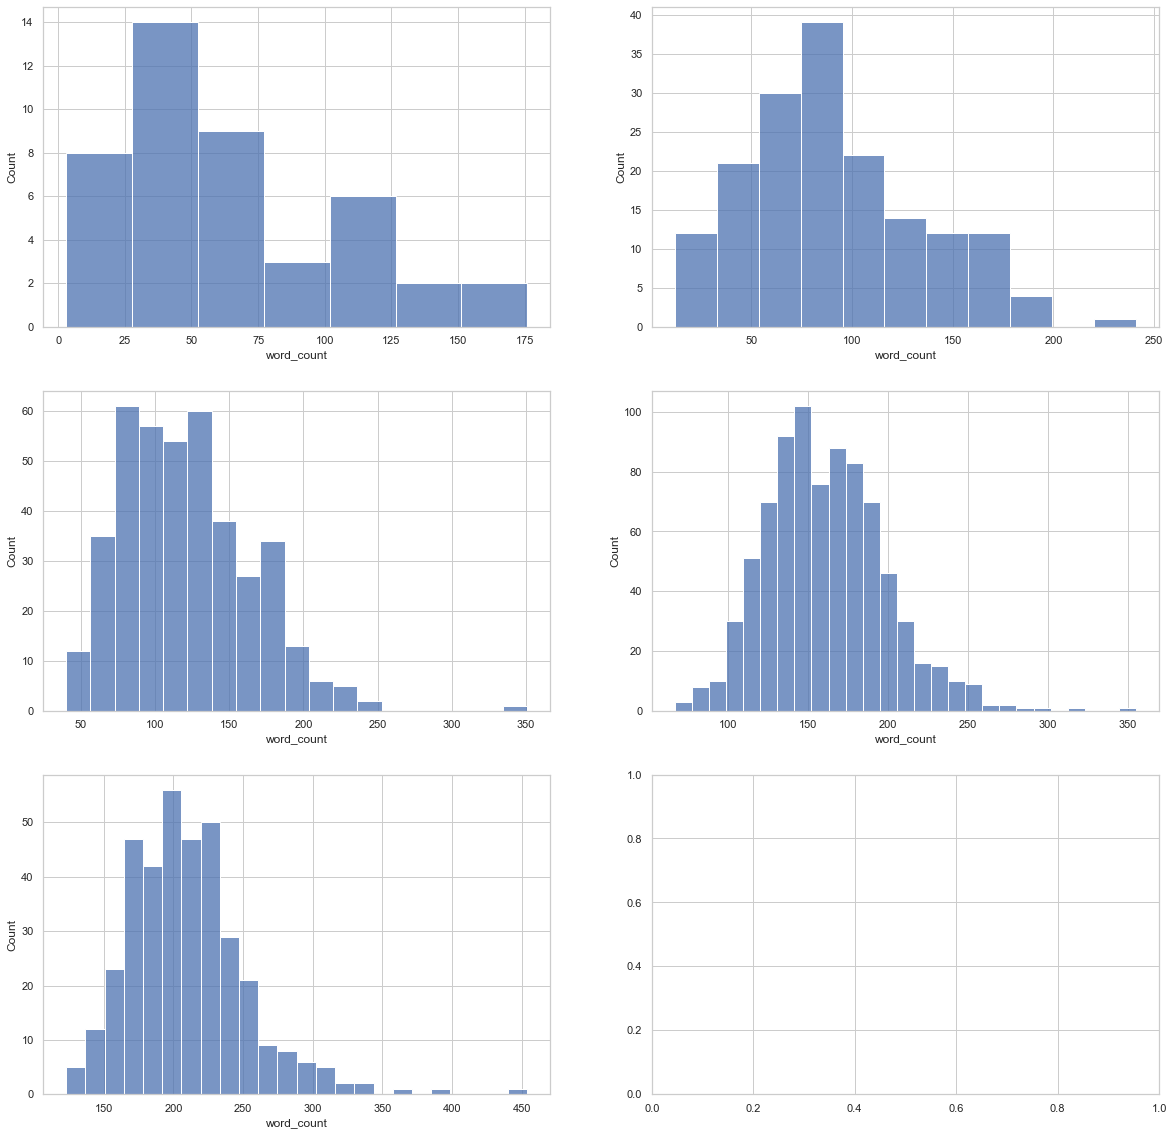

In [28]:
plot_word_length_each_score(6)

In [29]:
topic = data[data['essay_set'] == 6]
temp1 = topic[(topic['domain1_score'] == 0.2) & (topic['word_count'] < 10)]
temp2 = topic[(topic['domain1_score'] == 0.6) & (topic['word_count'] > 300)]
temp3 = topic[(topic['domain1_score'] == 1) & (topic['word_count'] > 350)]
temp = pd.concat([temp1, temp2, temp3])
data = data[~data.isin(temp)].dropna()
data.shape

(12926, 5)

## Remove outliers from set 7


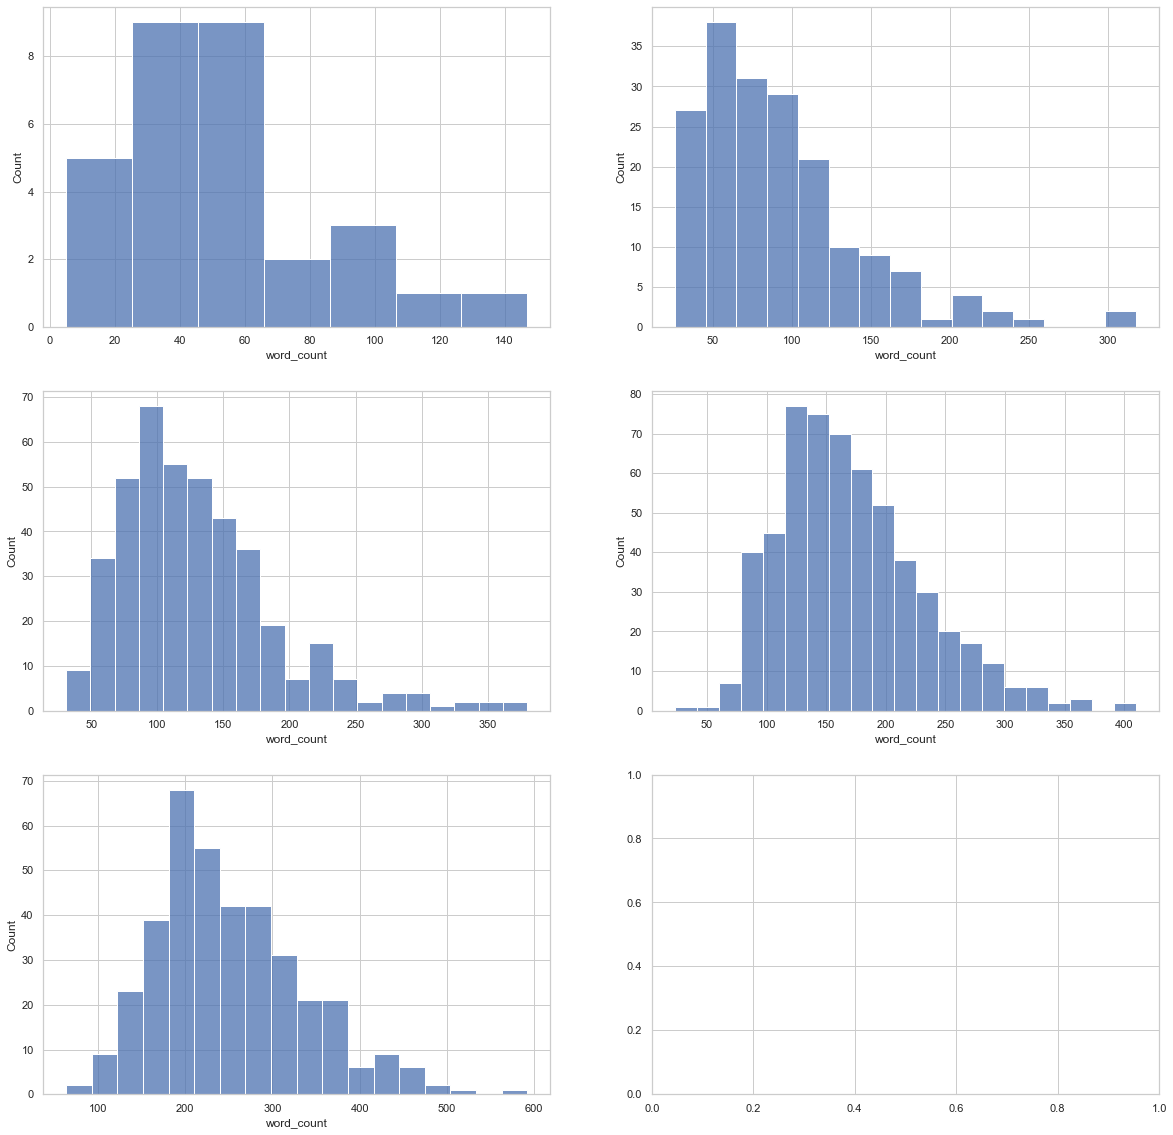

In [30]:
plot_word_length_each_score(7)

In [31]:
topic = data[data['essay_set'] == 7]
temp = topic[(topic['domain1_score'] == 0.2) & (topic['word_count'] < 10)]
data = data[~data.isin(temp)].dropna()
data.shape

(12925, 5)

## Remove outliers from set 8

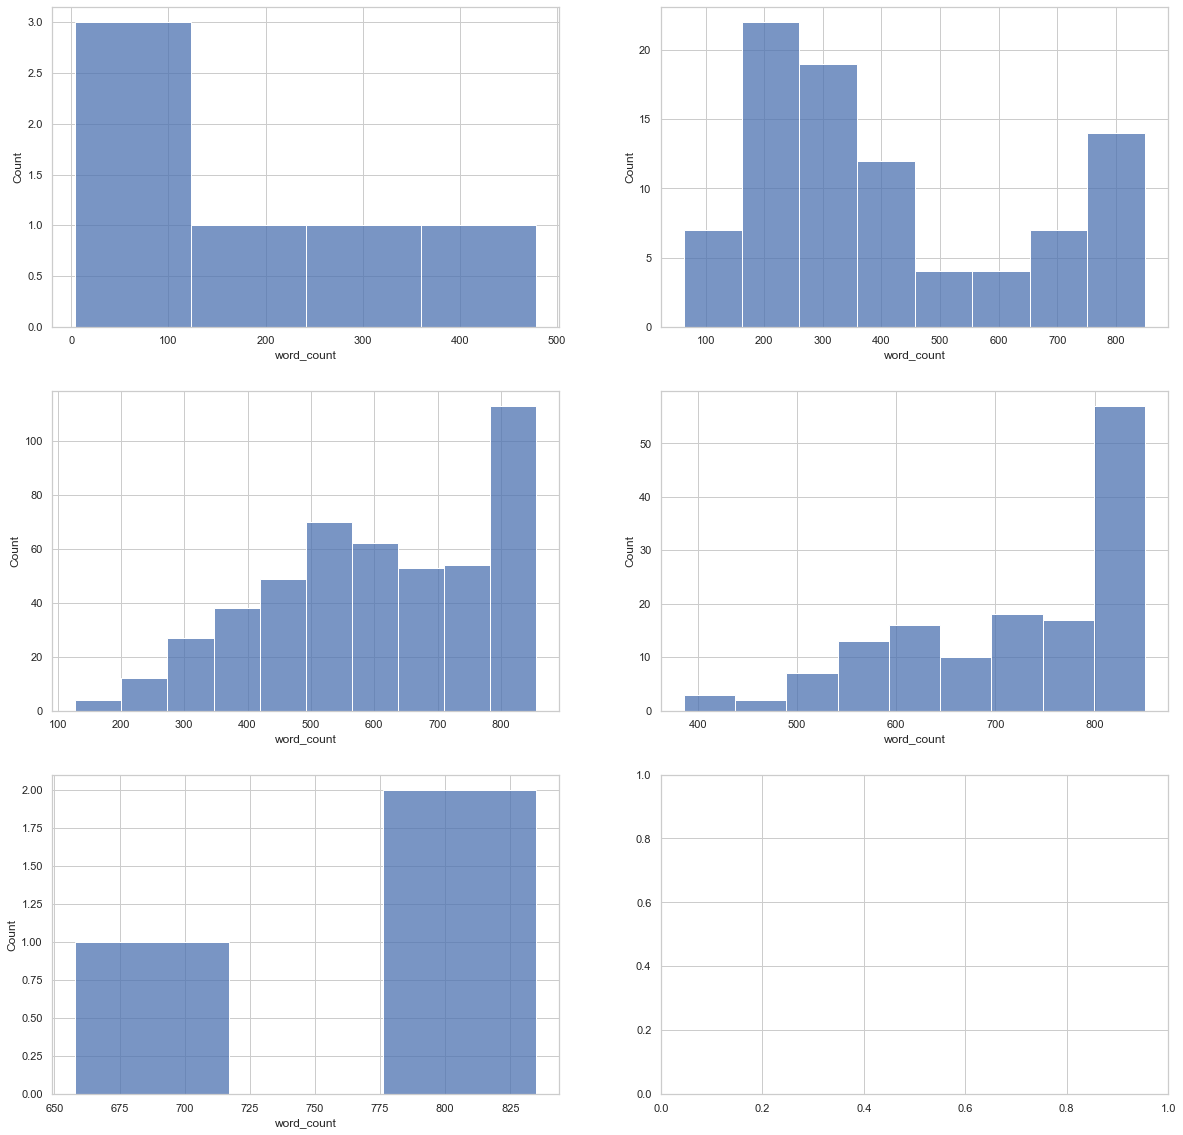

In [32]:
plot_word_length_each_score(8)

# Model

In [33]:
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model, load_model, model_from_config
import keras.backend as K
from sklearn.metrics import precision_score, f1_score, recall_score
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [34]:
test_df = data.copy()

test_df['domain1_score'] = test_df['domain1_score'].map({0.2: 1, 0.4: 2, 0.6: 3, 0.8: 4, 1: 5})

test_df.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",3,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",4,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",3,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",4,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",3,465.0


In [35]:
essay_sets, data_min_scores, data_max_scores = split_in_sets(test_df)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
sets = [set1, set2, set3, set4, set5, set6, set7, set8]
set1

Set 1 : Essays =  1774 	 Attributes =  5
Set 2 : Essays =  1784 	 Attributes =  5
Set 3 : Essays =  1720 	 Attributes =  5
Set 4 : Essays =  1764 	 Attributes =  5
Set 5 : Essays =  1799 	 Attributes =  5
Set 6 : Essays =  1793 	 Attributes =  5
Set 7 : Essays =  1568 	 Attributes =  5
Set 8 : Essays =  723 	 Attributes =  5


/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_30392/2675578851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_set.dropna(axis=1, inplace=True)


,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",3,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",4,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",3,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",4,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",3,465.0
...,...,...,...,...,...
1778,1783.0,1.0,"Dear @CAPS1, @CAPS2 several reasons on way I t...",3,497.0
1779,1784.0,1.0,Do a adults and kids spend to much time on the...,3,200.0
1780,1785.0,1.0,My opinion is that people should have computer...,3,291.0
1781,1786.0,1.0,"Dear readers, I think that its good and bad to...",1,15.0


In [36]:
set1.domain1_score.value_counts()

3    818
4    647
5    156
2    125
1     28
Name: domain1_score, dtype: int64

In [37]:
# Optimizers
sgd = SGD(learning_rate=1e-6, decay=0.000001)
rmsprop = RMSprop(learning_rate=1e-10, momentum=0.9)

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience= 2,
                              factor= 0.3,
                              min_lr= 1e-7,
                              verbose=1)

def get_model(Hidden_dim1=400, Hidden_dim2=200, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768, activation='relu', bidirectional = False):
    """Define the model."""
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(Hidden_dim1,return_sequences=return_sequences , dropout=0.4, recurrent_dropout=recurrent_dropout), input_shape=[1, input_size]))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout, return_sequences=return_sequences)))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(Hidden_dim1, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=[1, input_size], return_sequences=return_sequences))
        model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))

    model.add(Dropout(dropout))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
    model.summary()
    
    return model

In [47]:
def get_features(X):
    max_len = 0
    for i in X.values:
        if len(i) > max_len:
            max_len = len(i)

    padded_X = np.array([i + [0]*(max_len-len(i)) for i in X.values])
    attention_mask_X = np.where(padded_X != 0, 1, 0)
    X_input_ids = torch.tensor(padded_X)
    X_attention_mask = torch.tensor(attention_mask_X)

    with torch.no_grad():
        last_hidden_states_X = model(X_input_ids, attention_mask=X_attention_mask)

    X_features = last_hidden_states_X[0][:,0,:].numpy()

    return X_features


In [48]:
import time
import torch
import transformers as ppb
import warnings
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)
warnings.filterwarnings('ignore')

0.9.0


In [49]:
# ## Sets experiment BERT
#
# set_count = 1
# all_sets_score = []
#
# for s in sets:
#     print("\n--------SET {}--------\n".format(set_count))
#     X = s
#     y = s['domain1_score']
#     cv = KFold(n_splits=5, shuffle=True)
#     cv_data = cv.split(X)
#
#     kappa_results = []
#     f1_results = []
#     recall_results = []
#     precision_results = []
#     prediction_list = []
#     fold_count = 1
#
#     model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# #     model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
#
#     # Load pretrained model/tokenizer
#     tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#     model = model_class.from_pretrained(pretrained_weights)
#
#     # Train model
#     for traincv, testcv in cv_data:
#         print("\n--------Fold {}--------\n".format(fold_count))
#
#         # get the train and test from the dataset.
#         X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
#         train_essays = X_train['essay']
#         test_essays = X_test['essay']
#
#         sentences = []
#         tokenize_sentences = []
#         train_bert_embeddings = []
#
#         tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
#         tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
#
#         # test = pd.DataFrame(tokenized_train)
#         # print(train_essays.shape)
#         # print(train_essays.iloc[0])
#         # print(len(train_essays.iloc[0]))
#         # print(test)
#         # print(test.iloc[0, 0])
#         # print(len(test.iloc[0, 0]))
#
#
#         train_features = get_features(tokenized_train)
#         test_features = get_features(tokenized_test)
#
#         train_x, train_y = train_features.shape
#         test_x, test_y = test_features.shape
#
#         trainDataVectors = np.reshape(train_features,(train_x, 1, train_y))
#         testDataVectors = np.reshape(test_features,(test_x, 1, test_y))
#
#         # print(type(trainDataVectors))
#         # print(trainDataVectors.shape)
#         # print(trainDataVectors)
#
#         # Bidirectional LSTM Model
#         bi_dir_lstm_model = get_model(bidirectional=True)
#         bi_dir_lstm_model.fit(trainDataVectors, y_train, batch_size=100, epochs=70)
#
#         # Predict
#         y_pred = bi_dir_lstm_model.predict(testDataVectors)
#         y_pred = np.around(y_pred)
#         #y_pred.dropna()
#         np.nan_to_num(y_pred)
#
#         print(y_pred)
#         print(y_pred.shape)
#
#         # evaluate the model
#         kappa_score = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
#         # f1 = f1_score(y_test.values, y_pred, average='micro')
#         # recall = recall_score(y_test.values, y_pred, average='micro')
#         # precision = precision_score(y_test.values, y_pred, average='micro')
#
#         print(f'Kappa Score: {kappa_score}')
#         # print(f'F1 Score: {f1}')
#         # print(f'Recall Score: {recall}')
#         # print(f'Precision Score: {precision}')
#
#         kappa_results.append(kappa_score)
#         # f1_results.append(f1)
#         # recall_results.append(recall)
#         # precision_results.append(precision)
#
#         fold_count +=1
#         tf.keras.backend.clear_session()
#         all_sets_score.append(kappa_results)
#
#     print("Average kappa score value is : {}".format(np.mean(np.asarray(kappa_results))))
#     # print("Average f1 score value is : {}".format(np.mean(np.asarray(f1_results))))
#     # print("Average recall score value is : {}".format(np.mean(np.asarray(recall_results))))
#     # print("Average precision score value is : {}".format(np.mean(np.asarray(precision_results))))
#     set_count+=1

In [50]:
sets[0]

,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",3,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",4,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",3,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",4,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",3,465.0
...,...,...,...,...,...
1778,1783.0,1.0,"Dear @CAPS1, @CAPS2 several reasons on way I t...",3,497.0
1779,1784.0,1.0,Do a adults and kids spend to much time on the...,3,200.0
1780,1785.0,1.0,My opinion is that people should have computer...,3,291.0
1781,1786.0,1.0,"Dear readers, I think that its good and bad to...",1,15.0


In [51]:
## Sets experiment BERT
## Using SMOTE for imbalanced data

set_count = 1
all_sets_score = []

oversample = SMOTE()

for s in sets:
    print("\n--------SET {}--------\n".format(set_count))
    X = s
    y = s['domain1_score']
    cv = KFold(n_splits=5, shuffle=True)
    cv_data = cv.split(X)

    kappa_results = []
    f1_results = []
    recall_results = []
    precision_results = []
    acc_results = []
    prediction_list = []
    fold_count = 1

    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#     model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Train model
    for traincv, testcv in cv_data:
        print("\n--------Fold {}--------\n".format(fold_count))

        # get the train and test from the dataset.
        X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
        train_essays = X_train['essay']
        test_essays = X_test['essay']

        # sentences = []
        # tokenize_sentences = []
        # train_bert_embeddings = []

        tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200, truncation=True)))
        tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200, truncation=True)))

        # test = pd.DataFrame(tokenized_train)
        # print(train_essays.shape)
        # print(train_essays.iloc[0])
        # print(len(train_essays.iloc[0]))
        # print(test)
        # print(test.iloc[0, 0])
        # print(len(test.iloc[0, 0]))


        train_features = get_features(tokenized_train)
        test_features = get_features(tokenized_test)

        # # SMOTE
        # train_features, y_train = oversample.fit_resample(train_features, y_train)
        # # summarize the new class distribution
        # counter = Counter(y_train)
        # print(f'Class distribution: {counter}')

        train_x, train_y = train_features.shape
        test_x, test_y = test_features.shape

        trainDataVectors = np.reshape(train_features, (train_x, 1, train_y))
        testDataVectors = np.reshape(test_features, (test_x, 1, test_y))

        # print(type(train_features))
        # print(train_features.shape)
        # print(train_features)

        # y_train = pd.get_dummies(y_train)
        # y_test = pd.get_dummies(y_test)

        # Bidirectional LSTM Model
        bi_dir_lstm_model = get_model(bidirectional=True)
        bi_dir_lstm_model.fit(trainDataVectors, y_train, batch_size=100, epochs=100, validation_split=0.1)

        # # Predict
        y_pred = bi_dir_lstm_model.predict(testDataVectors)
        y_pred = np.around(y_pred)
        #y_pred.dropna()
        np.nan_to_num(y_pred)

        y_test = y_test.to_numpy().reshape(-1, 1)

        y_pred = y_pred.reshape(-1, 1)

        # print(y_test)
        # print(y_test.shape)
        # print(y_pred)
        # print(y_pred.shape)

        result_tbl = pd.DataFrame(data=np.concatenate((y_test, y_pred), axis=1),
                                  columns=['Test', 'Pred'])
        print(result_tbl)

        # evaluate the model
        kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
        f1 = f1_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        acc = model.evaluate(y_test, y_pred, verbose=0)

        print(f'Kappa Score: {kappa_score}')
        print(f'F1 Score: {f1}')
        print(f'Recall Score: {recall}')
        print(f'Precision Score: {precision}')
        print(f'Accuracy: {acc}')
        #
        kappa_results.append(kappa_score)
        f1_results.append(f1)
        recall_results.append(recall)
        precision_results.append(precision)
        acc_results.append(acc)
        #
        fold_count +=1
        tf.keras.backend.clear_session()
        # all_sets_score.append(kappa_results)

    print("Average kappa score value is : {}".format(np.mean(np.asarray(kappa_results))))
    print("Average f1 score value is : {}".format(np.mean(np.asarray(f1_results))))
    print("Average recall score value is : {}".format(np.mean(np.asarray(recall_results))))
    print("Average precision score value is : {}".format(np.mean(np.asarray(precision_results))))
     print("Average accuracy score value is : {}".format(np.mean(np.asarray(acc_results))))
    set_count+=1


--------SET 1--------



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



--------Fold 1--------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 800)           3740800   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 400)           1601600   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 128)               51328     
                               

2022-05-06 14:49:33.000455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 6.6132 - mse: 6.6132

2022-05-06 14:49:38.159671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 12s 253ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 2/100
13/13 [==============================] - 2s 129ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 3/100
13/13 [==============================] - 2s 128ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 4/100
13/13 [==============================] - 2s 125ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 5/100
13/13 [==============================] - 2s 128ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 6/100
13/13 [==============================] - 2s 128ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 7/100
13/13 [==============================] - 2s 126ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 6.6056 - val_mse: 6.6056
Epoch 8/100
13/13 [==============================] - 2s 125ms/step - loss: 6.613

KeyboardInterrupt: 

In [ ]:
num = 3.45

np.round(num)

In [ ]:
ess = data.iloc[0, 2]
print(ess)

import re
temp = re.findall(r"[\w']+|[.,!?;]", ess)
print(len(temp))
print(temp)

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

sen = 'Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of trouble! Thing about!'

sen2 = 'I love cafe, and I hate tea. Hi mom!'

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

token = tokenizer.encode(ess, add_special_tokens=True)
print(token)
print(len(token))

In [ ]:
import transformers as ppb
train_essays = data[:1]['essay']

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
train_features = get_features(tokenized_train)
train_features

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
testDataVectors = np.reshape(test_features,(test_x,test_y,1))
print(y_train.shape)
print(trainDataVectors.shape)

In [ ]:
# x = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
def plot_qwk_scores_all_sets():
  fig = plt.figure()
  ax = plt.subplot(111)
  x = [1,2,3,4,5]
  ax.plot(x, set1 , label='set1')
  ax.plot(x, set2, label='set2')
  ax.plot(x, set3, label='set3')
  ax.plot(x, set4, label='set4')
  ax.plot(x, set5, label='set5')
  ax.plot(x, set6, label='set6')
  ax.plot(x, set7, label='set7')
  ax.plot(x, set8, label='set8')
  plt.title('Set wise QWK using BERT for individual sets')
  ax.legend()
  plt.show()
